In [202]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os
# Conversion factors
mev_to_cm = 8.0655
cm_to_mev = 1.0 / mev_to_cm

In [203]:
class INS:
    def __init__(self, filenames, title=None, save_as='INS.svg', units_in='cm', units='meV', scale_range=[30,50], ylim_scale=2, xlim=50, hide_y_axis=True, log=False, legend=True):

        self.units = units
        
        if units_in is None:
            self.units_in = ['cm'] * len(filenames)
        elif isinstance(units_in, str):
            self.units_in = [units_in] * len(filenames)
        elif isinstance(units_in, list) and len(units_in) == len(filenames):
            self.units_in = units_in
        elif isinstance(units_in, list) and len(units_in) == 1:
            self.units_in = units_in * len(filenames)
        else:
            raise ValueError("units_in must be either a string, or a list of the same length as filenames.")

        self.title = title
        self.filenames = filenames
        self.dataframes = [self.read_ins(filename) for filename in filenames] if isinstance(filenames, list) else [self.read_ins(filenames)]
        self.xlim = xlim
        self.ylim_scale = ylim_scale
        self.hide_y_axis = hide_y_axis
        self.log = log
        self.scale_range = scale_range
        self.legend = legend
        self.save_as = save_as
        

    def read_ins(self, filename):
        mev = ['mev', 'meV', 'MEV']
        cm = ['cm', 'CM']
        root = os.getcwd()
        file = os.path.join(root, filename)
        df = pd.read_csv(file, comment='#')
        df = df.sort_values(by=df.columns[0])
        # Convert the energies
        if self.units in mev:
            if self.units_in[self.filenames.index(filename)] in cm:
                df[df.columns[0]] = df[df.columns[0]] * cm_to_mev
        elif self.units in cm:
            if self.units_in[self.filenames.index(filename)] in mev:
                df[df.columns[0]] = df[df.columns[0]] * mev_to_cm
        # if there are three columns, remove the third one
        if len(df.columns) > 3:
            df = df.drop(columns=df.columns[3])
        df.columns = [f'Energy transfer / {self.units}', 'S(Q,E)', 'Error']

        print(df.head())

        return df

In [204]:
def plot_ins(ins:INS):
    fig, ax = plt.subplots()

    # Limit max intensity to INS.ylim_scale times the MAPI peak of the 1st dataframe
    df0 = ins.dataframes[0]

    if ins.scale_range and len(ins.scale_range) == 2:
        range_start = ins.scale_range[0]
        range_end = ins.scale_range[1]
    else:
        range_start = 30
        range_end = 50

    df_range = df0[(df0[df0.columns[0]] >= range_start) & (df0[df0.columns[0]] <= range_end)]
    max_df = df_range[df_range.columns[1]].max()

    ax.set_xlim([0, ins.xlim])
    ax.set_ylim([0, ins.ylim_scale * max_df])

    strings_to_delete_from_name = ['.csv', '_INS', '_temp']
    for df, name in zip(ins.dataframes, ins.filenames):
        if ins.scale_range is not False:
            first_cut = ins.scale_range[0]
            second_cut = ins.scale_range[1]
            df_range_i = df[(df[df.columns[0]] >= first_cut) & (df[df.columns[0]] <= second_cut)]
            max_df_i = df_range_i[df_range_i.columns[1]].max()
            df[df.columns[1]] = df[df.columns[1]] / max_df_i * max_df
        name_clean = name
        for string in strings_to_delete_from_name:
            name_clean = name_clean.replace(string, '')
        df.plot(x=df.columns[0], y=df.columns[1], label=name_clean, ax=ax)

    plt.title(ins.title)
    plt.xlabel(df.columns[0])
    plt.ylabel(df.columns[1])

    if ins.log:
        ax.set_xscale_range('log')
    if ins.hide_y_axis:
        ax.set_yticks([])
    if ins.legend:
        ax.legend()
    else:
        ax.legend().set_visible(False)

    root = os.getcwd()
    save_name = os.path.join(root, ins.save_as)
    # plt.savefig(save_name)
    plt.show()

In [205]:
def deuteration_mapi(ins:INS, baseline=0.15, baseline_error=0.0):

    df3_lowcut = 28.8
    df3_highcut = 30.7
    df4_lowcut = df3_highcut
    df4_highcut = 33.0
    df5_lowcut = df4_highcut
    df5_highcut = 35.0
    df6_lowcut = 36.0
    df6_highcut = 39.0

    df = ins.dataframes[0].copy()
    df[df.columns[1]] = df[df.columns[1]] - baseline

    df3 = df[(df[df.columns[0]] >= df3_lowcut) & (df[df.columns[0]] <= df3_highcut)]
    df4 = df[(df[df.columns[0]] >= df4_lowcut) & (df[df.columns[0]] <= df4_highcut)]
    df5 = df[(df[df.columns[0]] >= df5_lowcut) & (df[df.columns[0]] <= df5_highcut)]
    df6 = df[(df[df.columns[0]] >= df6_lowcut) & (df[df.columns[0]] <= df6_highcut)]

    df3_area = scipy.integrate.simpson(df3[df3.columns[1]], x=df3[df3.columns[0]]) / 3
    df4_area = scipy.integrate.simpson(df4[df4.columns[1]], x=df4[df4.columns[0]]) / 4
    df5_area = scipy.integrate.simpson(df5[df5.columns[1]], x=df5[df5.columns[0]]) / 5
    df6_area = scipy.integrate.simpson(df6[df6.columns[1]], x=df6[df6.columns[0]]) / 6

    total_area = df3_area + df4_area + df5_area + df6_area

    df3_ratio = df3_area / total_area
    df4_ratio = df4_area / total_area
    df5_ratio = df5_area / total_area
    df6_ratio = df6_area / total_area

    deuteration = 1 * df3_ratio + (2/3) * df4_ratio + (1/3) * df5_ratio + 0 * df6_ratio
    protonation = 0 * df3_ratio + (1/3) * df4_ratio + (2/3) * df5_ratio + 1 * df6_ratio

    # Error propagation

    df3_area_error = 0
    df4_area_error = 0
    df5_area_error = 0
    df6_area_error = 0
    for error in df3['Error']:
        df3_area_error += error**2
    for error in df4['Error']:
        df4_area_error += error**2
    for error in df5['Error']:
        df5_area_error += error**2
    for error in df6['Error']:
        df6_area_error += error**2
    df3_area_error = np.sqrt(df3_area_error + baseline_error**2)
    df4_area_error = np.sqrt(df4_area_error + baseline_error**2)
    df5_area_error = np.sqrt(df5_area_error + baseline_error**2)
    df6_area_error = np.sqrt(df6_area_error + baseline_error**2)

    total_area_error = np.sqrt(df3_area_error**2 + df4_area_error**2 + df5_area_error**2 + df6_area_error**2)

    df3_error = abs(df3_area) * np.sqrt((df3_area_error/df3_area)**2 + (total_area_error/total_area)**2)
    df4_error = abs(df4_area) * np.sqrt((df4_area_error/df4_area)**2 + (total_area_error/total_area)**2)
    df5_error = abs(df5_area) * np.sqrt((df5_area_error/df5_area)**2 + (total_area_error/total_area)**2)
    df6_error = abs(df6_area) * np.sqrt((df6_area_error/df6_area)**2 + (total_area_error/total_area)**2)

    deuteration_error = np.sqrt(df3_error**2 + df4_error**2 + df5_error**2)
    protonation_error = np.sqrt(df6_error**2 + df5_error**2 + df4_error**2)

    print(f"DDD:  {round(df3_ratio,2)}  +-  {round(df3_error,2)}")
    print(f"DDH:  {round(df4_ratio,2)}  +-  {round(df4_error,2)}")
    print(f"DHH:  {round(df5_ratio,2)}  +-  {round(df5_error,2)}")
    print(f"HHH:  {round(df6_ratio,2)}  +-  {round(df6_error,2)}")
    print(f"Total deuteration:  {round(deuteration,2)}  +-  {round(deuteration_error,2)}")
    print(f"Total protonation:  {round(protonation,2)}  +-  {round(protonation_error,2)}")

In [206]:
def get_baseline(ins:INS, lowcut=27, highcut=35):
    df = ins.dataframes[0]
    df_range = df[(df[df.columns[0]] >= lowcut) & (df[df.columns[0]] <= highcut)]
    x = df_range[df.columns[0]]
    y = df_range['S(Q,E)']
    error_range = df_range['Error']

    # Perform a weighted least squares fit
    degree = 1
    weights = 1.0 / error_range**2
    coefficients = np.polyfit(x, y, degree, w=weights)
    polynomial = np.poly1d(coefficients)

    # Calculate the baseline
    baseline = polynomial(x)

    # Calculate the standard deviation of the residuals
    residuals = y - baseline
    error_std = np.std(residuals)

    baseline_value = np.mean(baseline)

    return baseline_value, error_std

In [207]:
ins_data_protonated = INS(filenames=['CH3NH3PbI3.csv'], title=None, scale_range=[5,20], ylim_scale=1.3, save_as='INS_protonated.svg', hide_y_axis=False)
ins_data_deuterated = INS(filenames=['CH3ND3PbI3.csv'], title=None, scale_range=[5,20], ylim_scale=1.3, save_as='INS_deuterated.svg', hide_y_axis=False)
ins_data_02 = INS(filenames=['IREPA-ND-02_INS.csv'], title=None, scale_range=[5,20], ylim_scale=1.3, save_as='INS_irepa-nd-02.svg', hide_y_axis=False)

   Energy transfer / meV    S(Q,E)     Error
0              -2.477515 -0.004280  0.003220
1              -2.462513  0.006404  0.005025
2              -2.447511 -0.000348  0.004265
3              -2.432509  0.002058  0.004282
4              -2.417519 -0.001935  0.005215
   Energy transfer / meV    S(Q,E)     Error
0              -2.477515  0.002103  0.003769
1              -2.462513  0.002079  0.003821
2              -2.447511  0.002031  0.003964
3              -2.432509  0.003785  0.003885
4              -2.417519 -0.001704  0.004760
   Energy transfer / meV    S(Q,E)     Error
0              -2.477515 -0.004492  0.003178
1              -2.462513 -0.000690  0.004243
2              -2.447511  0.000412  0.004805
3              -2.432509 -0.000419  0.004242
4              -2.417519 -0.008563  0.004287


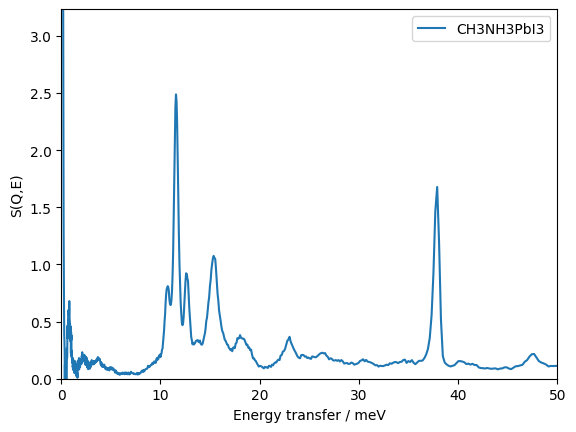

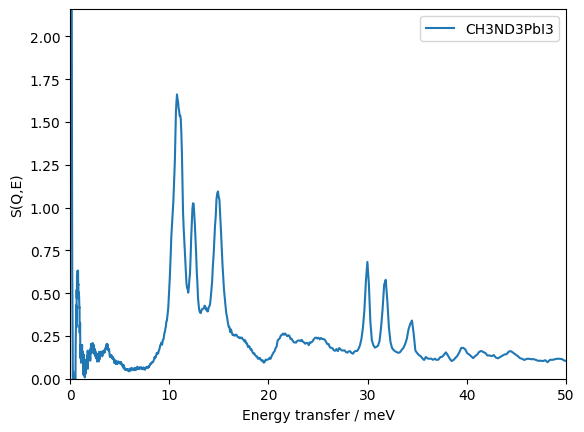

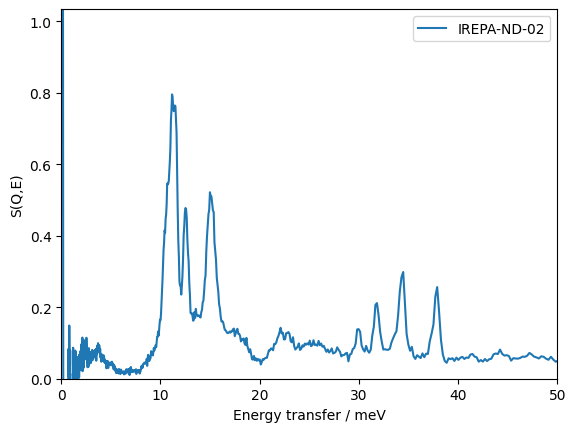

In [208]:
plot_ins(ins_data_protonated)
plot_ins(ins_data_deuterated)
plot_ins(ins_data_02)

In [209]:
baseline_H, baseline_error_H = get_baseline(ins_data_protonated, lowcut=27, highcut=36)
baseline_D, baseline_error_D = get_baseline(ins_data_deuterated, lowcut=35, highcut=41)

print(f'Baseline H:  {baseline_H:.3}  +-  {baseline_error_H:.2}')
print(f'Baseline D:  {baseline_D:.3}  +-  {baseline_error_D:.2}')

baseline = np.mean([baseline_H, baseline_D])
baseline_error = baseline * np.sqrt((baseline_error_H/baseline_H)**2 + (baseline_error_D/baseline_D)**2)

print(f'Baseline mean:  {baseline:.3}  +-  {baseline_error:.2}')

Baseline H:  0.139  +-  0.017
Baseline D:  0.13  +-  0.018
Baseline mean:  0.134  +-  0.025


In [210]:
deuteration_mapi(ins_data_protonated, baseline, baseline_error)

DDD:  0.02  +-  0.04
DDH:  -0.02  +-  0.04
DHH:  0.02  +-  0.03
HHH:  0.98  +-  0.09
Total deuteration:  0.01  +-  0.06
Total protonation:  0.99  +-  0.1


In [211]:
deuteration_mapi(ins_data_deuterated, baseline, baseline_error)

DDD:  0.51  +-  0.05
DDH:  0.37  +-  0.04
DHH:  0.14  +-  0.03
HHH:  -0.03  +-  0.03
Total deuteration:  0.81  +-  0.07
Total protonation:  0.19  +-  0.06


In [212]:
deuteration_mapi(ins_data_02, baseline, baseline_error) # BASELINE IS DIFFERENT

DDD:  0.82  +-  0.07
DDH:  0.31  +-  0.04
DHH:  -0.49  +-  0.05
HHH:  0.37  +-  0.05
Total deuteration:  0.86  +-  0.1
Total protonation:  0.14  +-  0.08
